# Урок 1 Структура

In [1]:
import numpy as np
from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import tensorflow as tf

In [7]:
OUTPUT_CHANNELS = 3

In [20]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[160, 160, 3], include_top=False)

# Use the activations of these layers to form skip connections
layer_names = [
    'block_1_expand_relu',   # 80x80
    'block_3_expand_relu',   # 40x40
    'block_6_expand_relu',   # 20x20
    'block_13_expand_relu',  # 10x10
    'block_16_project',      # 5x5
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,
                            name='pretrained_mobilenet')

down_stack.trainable = False

In [21]:
def upsample(filters, size, name):
  return tf.keras.Sequential([
     tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.ReLU()
  ], name=name)

up_stack = [
    upsample(512, 3, 'upsample_5x5_to_10x10'),
    upsample(256, 3, 'upsample_10x10_to_20x20'),
    upsample(128, 3, 'upsample_20x20_to_40x40'),
    upsample(64, 3,  'upsample_40x40_to_80x80')
]

In [27]:
import re

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[160, 160, 3], name='input_image')

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for idx, (up, skip) in enumerate(zip(up_stack, skips)):
    x = up(x)
    concat = tf.keras.layers.Concatenate(name='expand_{}'.format(idx))
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #80x80 -> 160x160

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [28]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

# Скачиваем данные

In [2]:
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
!
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  86.3M      0  0:00:08  0:00:08 --:--:-- 97.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  36.7M      0 --:--:-- --:--:-- --:--:-- 36.7M



Подготовим пути входных изображений и целевые маски сегментации

In [3]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 2

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [4]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

Подготовьте набор данных для загрузки и векторизации пакетов данных

In [13]:
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

In [24]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Возвращает набор данных TF."""
    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Метки основной истины — 1, 2, 3. Вычтите единицу, чтобы получить 0, 1, 2
        target_img -= 1
        return input_img, target_img
    # Для более быстрой отладки ограничьте размер данных
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [51]:
import random

limit = 10

In [52]:
# Разделите наши пути img на обучающий и проверочный набор.
val_samples = limit
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Создать экземпляр набора данных для каждого разделения
# Ограничьте входные файлы в `max_dataset_len` для ускорения времени обучения эпохи.
# Удалите аргумент `max_dataset_len` при работе с полным набором данных.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=limit,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [30]:
epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2,
)

Epoch 1/50
5/5 - 0s - loss: 0.1853 - accuracy: 0.9433 - val_loss: 1.8699 - val_accuracy: 0.6343 - 190ms/epoch - 38ms/step
Epoch 2/50
5/5 - 0s - loss: 0.1615 - accuracy: 0.9524 - val_loss: 1.6229 - val_accuracy: 0.6524 - 181ms/epoch - 36ms/step
Epoch 3/50
5/5 - 0s - loss: 0.1450 - accuracy: 0.9592 - val_loss: 1.8205 - val_accuracy: 0.6295 - 174ms/epoch - 35ms/step
Epoch 4/50
5/5 - 0s - loss: 0.1375 - accuracy: 0.9609 - val_loss: 1.5882 - val_accuracy: 0.6544 - 163ms/epoch - 33ms/step
Epoch 5/50
5/5 - 0s - loss: 0.1293 - accuracy: 0.9633 - val_loss: 1.3667 - val_accuracy: 0.6807 - 156ms/epoch - 31ms/step
Epoch 6/50
5/5 - 0s - loss: 0.1127 - accuracy: 0.9688 - val_loss: 1.3369 - val_accuracy: 0.6761 - 160ms/epoch - 32ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0997 - accuracy: 0.9731 - val_loss: 1.4700 - val_accuracy: 0.6550 - 160ms/epoch - 32ms/step
Epoch 8/50
5/5 - 0s - loss: 0.0932 - accuracy: 0.9748 - val_loss: 1.3325 - val_accuracy: 0.6766 - 160ms/epoch - 32ms/step
Epoch 9/50
5/5 - 0s - lo

In [36]:
import keras.utils

In [31]:
from PIL import Image as Im

In [37]:
def display_mask(i):
    """Быстрая утилита для отображения прогноза модели"""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    img = img.resize((500, 500), Im.LANCZOS)
    display(img)

In [38]:
def check_one_image(i):
  # Отображение входного изображения
  display(Image(filename=val_input_img_paths[i]))

  # Отображение истинной маски и
  img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
  display(img)

  # Отображение предсказанной маски
  display_mask(i)


In [53]:
val_preds = model.predict(valid_dataset)

5/5 [==============================] - 0s 16ms/step


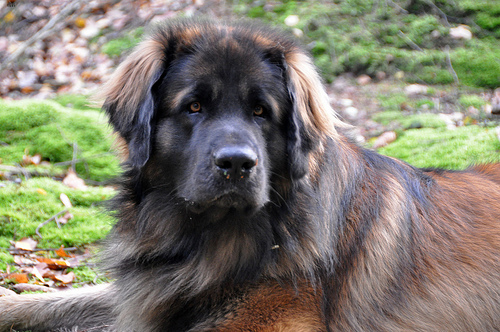

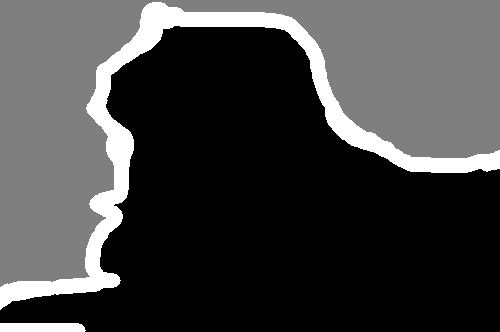

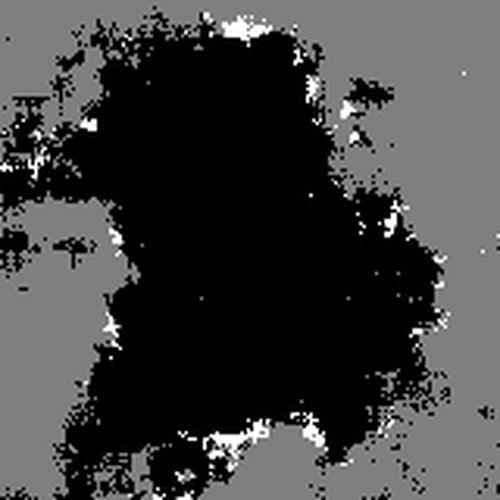

In [54]:
check_one_image(0)

# Увеличиваем количество обучающих примеров

In [40]:
model_2 = unet_model(OUTPUT_CHANNELS)
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [60]:
def create_datasets(limit):
  val_samples = limit
  random.Random(1337).shuffle(input_img_paths)
  random.Random(1337).shuffle(target_img_paths)
  train_input_img_paths = input_img_paths[:-val_samples]
  train_target_img_paths = target_img_paths[:-val_samples]
  val_input_img_paths = input_img_paths[-val_samples:]
  val_target_img_paths = target_img_paths[-val_samples:]

  # Создать экземпляр набора данных для каждого разделения
  # Ограничьте входные файлы в `max_dataset_len` для ускорения времени обучения эпохи.
  # Удалите аргумент `max_dataset_len` при работе с полным набором данных.
  train_dataset = get_dataset(
      batch_size,
      img_size,
      train_input_img_paths,
      train_target_img_paths,
      max_dataset_len=limit,
  )
  valid_dataset = get_dataset(
      batch_size, img_size, val_input_img_paths, val_target_img_paths
  )
  return train_dataset, valid_dataset

In [61]:
train_dataset, valid_dataset = create_datasets(500)

In [43]:
epochs = 50
model_2.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2,
)

Epoch 1/50
250/250 - 15s - loss: 0.6772 - accuracy: 0.7309 - val_loss: 0.6558 - val_accuracy: 0.7517 - 15s/epoch - 59ms/step
Epoch 2/50
250/250 - 6s - loss: 0.5886 - accuracy: 0.7661 - val_loss: 0.5933 - val_accuracy: 0.7664 - 6s/epoch - 22ms/step
Epoch 3/50
250/250 - 6s - loss: 0.5610 - accuracy: 0.7777 - val_loss: 0.5518 - val_accuracy: 0.7797 - 6s/epoch - 25ms/step
Epoch 4/50
250/250 - 7s - loss: 0.5410 - accuracy: 0.7857 - val_loss: 0.5673 - val_accuracy: 0.7727 - 7s/epoch - 29ms/step
Epoch 5/50
250/250 - 8s - loss: 0.5229 - accuracy: 0.7929 - val_loss: 0.5611 - val_accuracy: 0.7760 - 8s/epoch - 31ms/step
Epoch 6/50
250/250 - 6s - loss: 0.5041 - accuracy: 0.8001 - val_loss: 0.5569 - val_accuracy: 0.7824 - 6s/epoch - 24ms/step
Epoch 7/50
250/250 - 6s - loss: 0.4857 - accuracy: 0.8072 - val_loss: 0.5651 - val_accuracy: 0.7838 - 6s/epoch - 25ms/step
Epoch 8/50
250/250 - 6s - loss: 0.4653 - accuracy: 0.8151 - val_loss: 0.5640 - val_accuracy: 0.7856 - 6s/epoch - 26ms/step
Epoch 9/50
250

In [57]:
val_preds = model_2.predict(valid_dataset)

250/250 [==============================] - 2s 10ms/step


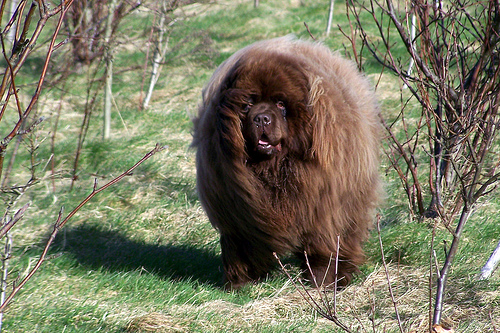

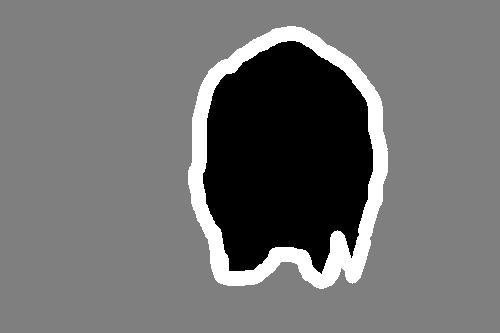

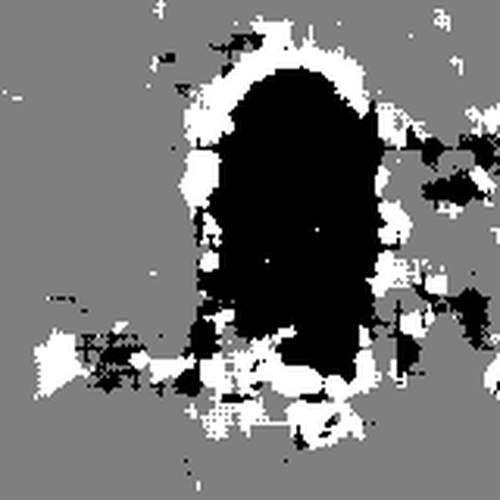

In [58]:
check_one_image(0)

# Увеличим количество обучающих примеров в 4 раза, уменьшим количество эпох в 4 раза

In [62]:
train_dataset, valid_dataset = create_datasets(2000)

In [63]:
model_3 = unet_model(OUTPUT_CHANNELS)
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [67]:
epochs = 12
model_3.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    verbose=2,
)

Epoch 1/12
1000/1000 - 31s - loss: 0.2955 - accuracy: 0.8839 - val_loss: 0.6530 - val_accuracy: 0.7883 - 31s/epoch - 31ms/step
Epoch 2/12
1000/1000 - 36s - loss: 0.2022 - accuracy: 0.9199 - val_loss: 0.7312 - val_accuracy: 0.7854 - 36s/epoch - 36ms/step
Epoch 3/12
1000/1000 - 36s - loss: 0.1805 - accuracy: 0.9281 - val_loss: 0.8008 - val_accuracy: 0.7831 - 36s/epoch - 36ms/step
Epoch 4/12
1000/1000 - 36s - loss: 0.1701 - accuracy: 0.9320 - val_loss: 0.8811 - val_accuracy: 0.7857 - 36s/epoch - 36ms/step
Epoch 5/12
1000/1000 - 26s - loss: 0.1630 - accuracy: 0.9348 - val_loss: 0.9074 - val_accuracy: 0.7834 - 26s/epoch - 26ms/step
Epoch 6/12
1000/1000 - 25s - loss: 0.1596 - accuracy: 0.9360 - val_loss: 0.9496 - val_accuracy: 0.7941 - 25s/epoch - 25ms/step
Epoch 7/12
1000/1000 - 26s - loss: 0.1629 - accuracy: 0.9350 - val_loss: 0.9385 - val_accuracy: 0.7928 - 26s/epoch - 26ms/step
Epoch 8/12
1000/1000 - 26s - loss: 0.1555 - accuracy: 0.9378 - val_loss: 0.9392 - val_accuracy: 0.7916 - 26s/ep

In [68]:
val_preds = model_3.predict(valid_dataset)

1000/1000 [==============================] - 11s 11ms/step


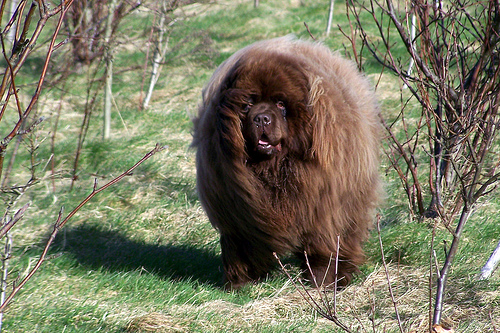

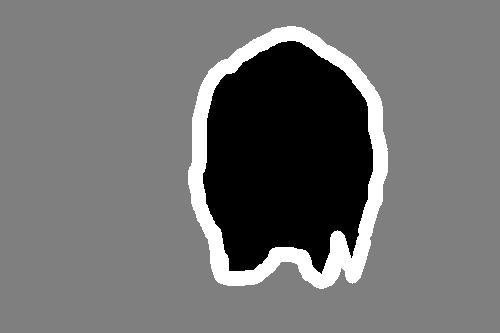

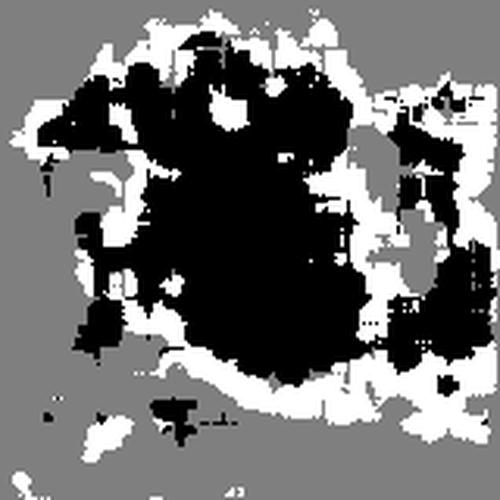

In [69]:
check_one_image(0)